In [8]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import os

def calculate_distance_from_point_to_station(row, given_point_coord):
    station_coord = (row['LATITUDE:'], row['LONGITUDE:'])
    # given_point_coord = (-15.789343, -47.925756)
    return geodesic(station_coord, given_point_coord).kilometers

df_all_stations = pd.read_csv("../data/all_stations.csv", decimal=",", sep=";")

# given_point_coord = (-16.012222, -47.557417)
# df_all_stations["Distancia"] = df_all_stations.apply(lambda x: calculate_distance_from_point_to_station(x, given_point_coord), axis=1) 

# df_nearest_stations = df_all_stations[df_all_stations["Distancia"] < 50]

# df_point_stations = df_all_stations[df_all_stations["Distancia"] < 1]

# Estaçoes do DF
codes_of_stations_to_analyze = ["A001", "A042", "A045", "A046", "A047"]

stations_data = []

# stations_files_to_read = set()

for code in codes_of_stations_to_analyze:
    station_info = df_all_stations[df_all_stations["CODIGO (WMO):"] == code]

    latitude = station_info["LATITUDE:"].iloc[0]
    longitude = station_info["LONGITUDE:"].iloc[0]

    station_coord = (latitude, longitude)

    df_all_stations["Distancia"] = df_all_stations.apply(lambda x: calculate_distance_from_point_to_station(x, station_coord), axis=1) 
    df_nearest_stations = df_all_stations[(df_all_stations["Distancia"] != 0) & (df_all_stations["Distancia"] < 50)]

    station_data = { 
        "code": code,
        "station_info": station_info,
        "nearest_stations_info": df_nearest_stations,
    }

    # df_nearest_stations["Arquivo"].apply(lambda x: stations_files_to_read.add(x))
    # stations_files_to_read.add(station_info["Arquivo"].iloc[0])
    stations_data.append(station_data)

print(stations_data)
# print(stations_files_to_read)

[{'code': 'A001', 'station_info':     REGI?O: UF:  ESTAC?O: CODIGO (WMO):   LATITUDE:  LONGITUDE: ALTITUDE:  \
442      CO  DF  BRASILIA          A001  -15.789343  -47.925756   1160.96   

                                               Arquivo  
442  INMET_CO_DF_A001_BRASILIA_01-01-2019_A_31-12-2...  , 'nearest_stations_info':     REGI?O: UF:            ESTAC?O: CODIGO (WMO):     LATITUDE:    LONGITUDE:  \
2        CO  DF  PARANOA (COOPA-DF)          A047    -16.012222    -47.557417   
141      CO  DF          BRAZLANDIA          A042  -15.59972221   -48.1311111   
233      CO  DF     AGUAS EMENDADAS          A045    -15.596491    -47.625801   
239      CO  DF   GAMA (PONTE ALTA)          A046  -15.93527777  -48.13749999   

    ALTITUDE:                                            Arquivo  Distancia  
2      1043.0  INMET_CO_DF_A047_PARANOA (COOPA-DF)_01-01-2019...  46.520207  
141    1143.0  INMET_CO_DF_A042_BRAZLANDIA_01-01-2019_A_31-12...  30.411300  
233   1030.36  INMET_CO_DF_A045

In [9]:
# yeardirectoryfilename = []
# df_nearest_stations_weather_data = []

# stations_dataframes = {
    
# }

def read_station_data(filename, start_year, end_year):
    station_data = []

    for year in range(start_year, end_year + 1):
        file = f'../data/cleaned_data/{year}_cleaned/{filename.replace("2019", str(year))}'
        df_weather_data = pd.read_csv(file, decimal=".", sep=";")
        station_data.append(df_weather_data)

    return pd.concat(station_data, ignore_index= True)

for station in stations_data:
    station_info = station["station_info"]
    station_file_name = station_info["Arquivo"].iloc[0]

    station["station_data"] = read_station_data(station_file_name, 2019, 2023)

    nearest_stations_data = []
    for index, nearest_station in station["nearest_stations_info"].iterrows():
        nearest_station_file_name = nearest_station["Arquivo"]
        nearest_station_data = read_station_data(nearest_station_file_name, 2019, 2023)

        nearest_stations_data.append(nearest_station_data)

    nearest_stations_data_compilation = pd.concat(nearest_stations_data, ignore_index= True)

    station["nearest_stations_data"] = nearest_stations_data_compilation

MSE: 2.4557349606582335
RMSE: 1.5670784794190218
sMAPE: 5.601634017135684


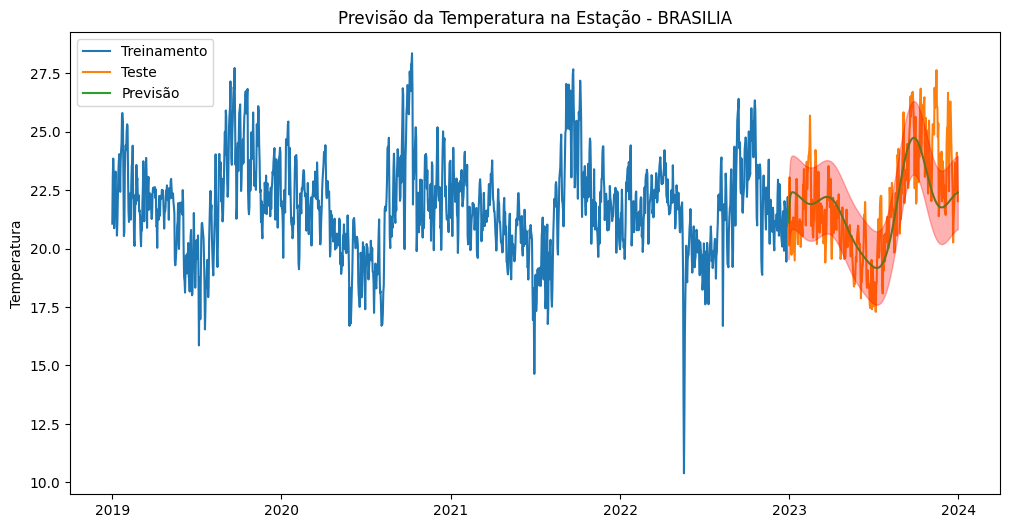

MSE: 3.5451449510398616
RMSE: 1.882855531112215
sMAPE: 6.750398517599216


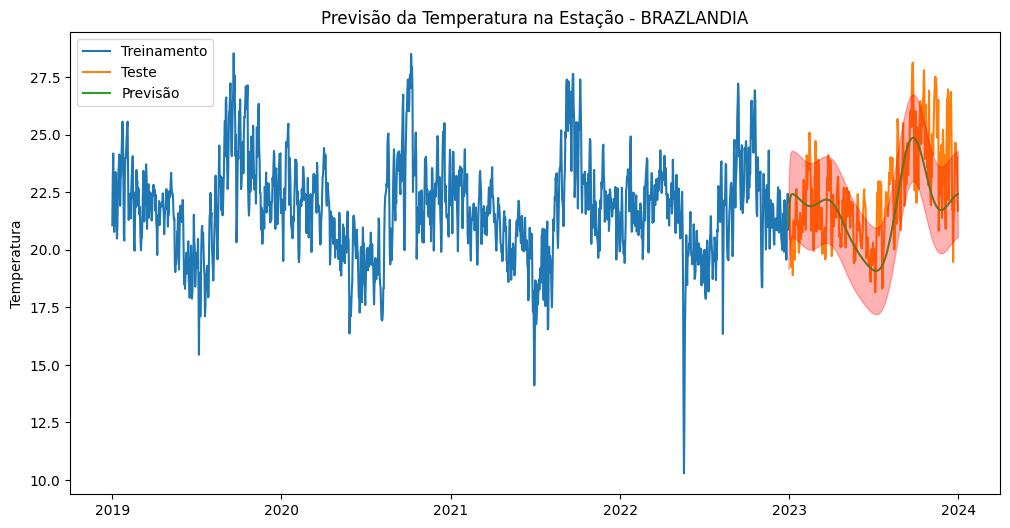

MSE: 2.6357168684450145
RMSE: 1.6234891032726442
sMAPE: 5.5641066156102506


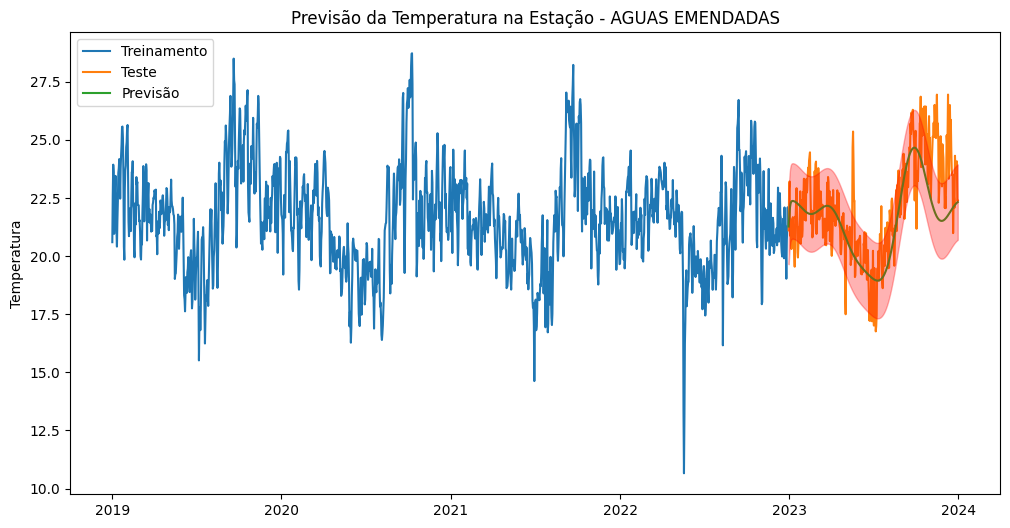

MSE: 3.1499384020256542
RMSE: 1.7748065815816816
sMAPE: 6.072739008648823


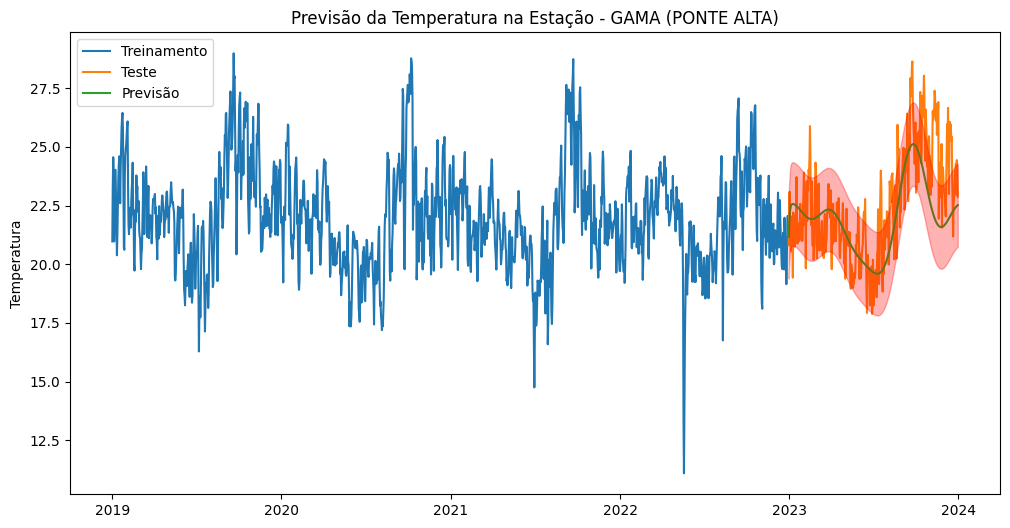

MSE: 3.9968976080309657
RMSE: 1.9992242515613314
sMAPE: 6.89334092673987


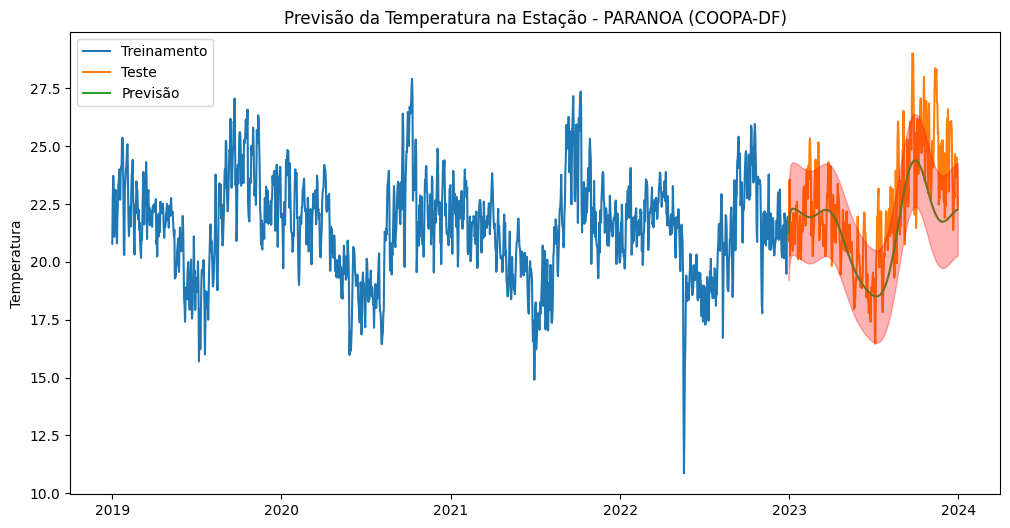

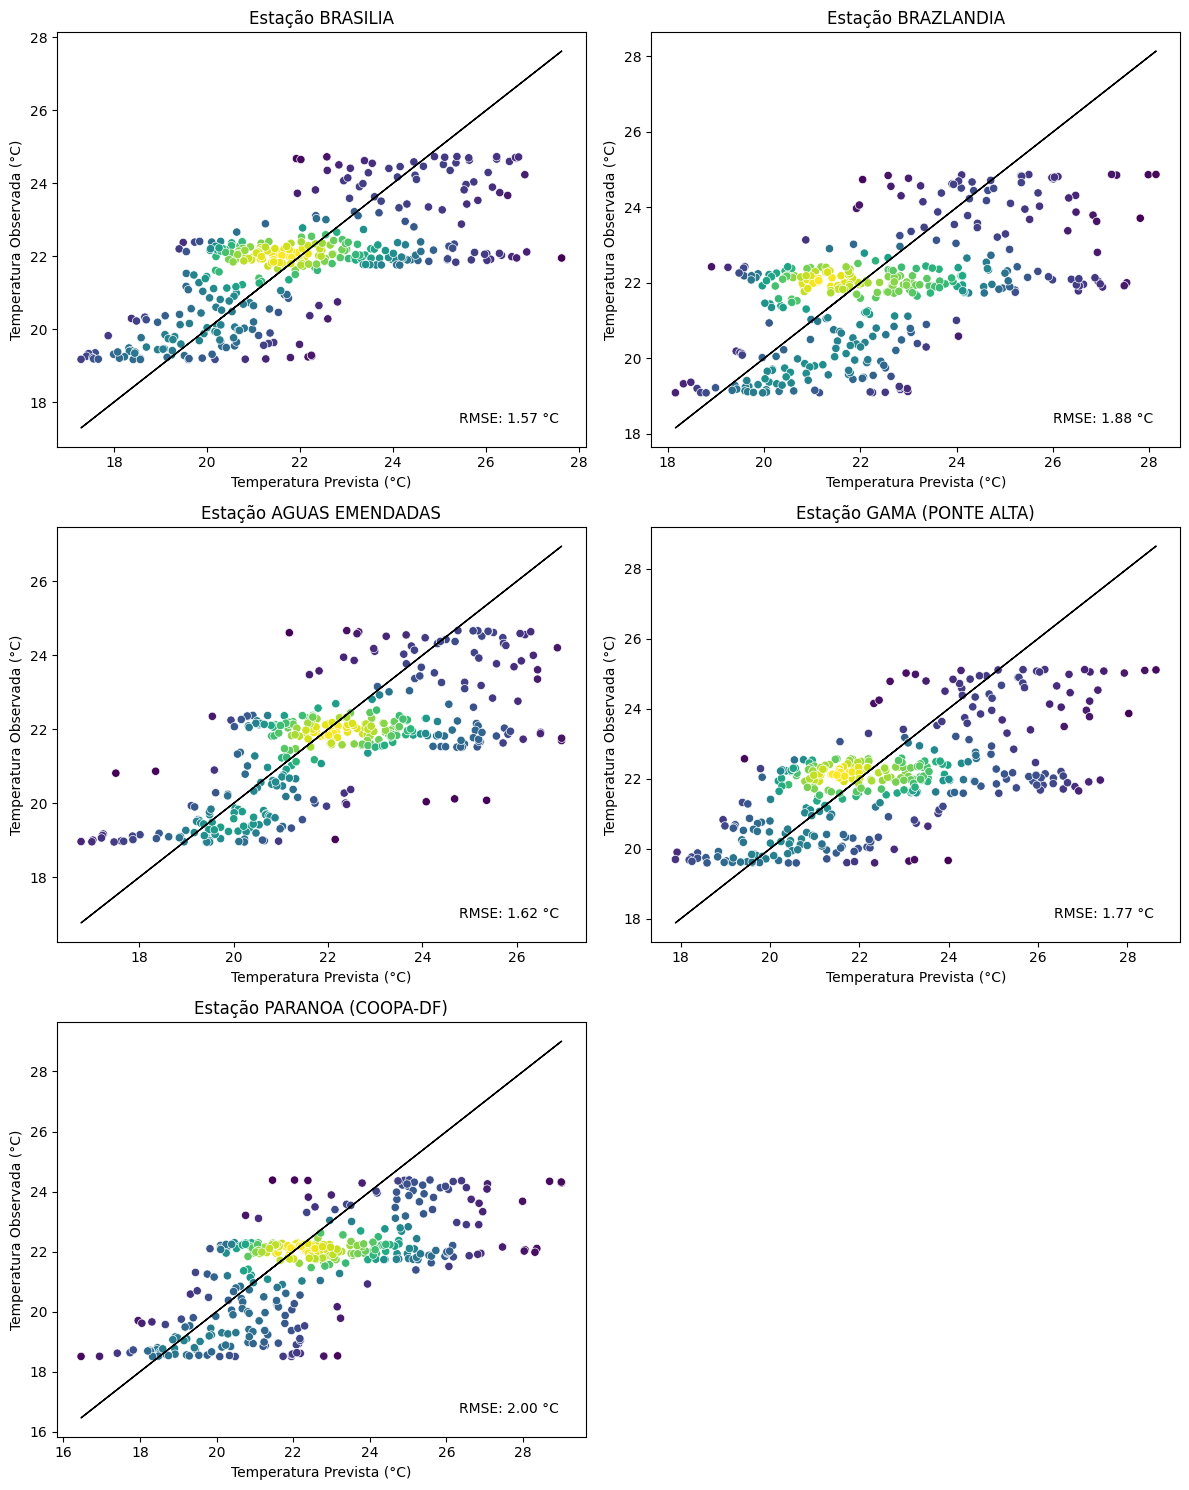

/home/juliababa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                            SARIMAX Results                                             
Dep. Variable:     TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)   No. Observations:                 1460
Model:                                           ARIMA(3, 0, 1)   Log Likelihood               -1513.139
Date:                                          Sat, 28 Jun 2025   AIC                           3060.277
Time:                                                  22:01:25   BIC                           3150.143
Sample:                                              01-01-2019   HQIC                          3093.801
                                                   - 12-30-2022                                         
Covariance Type:                                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
co

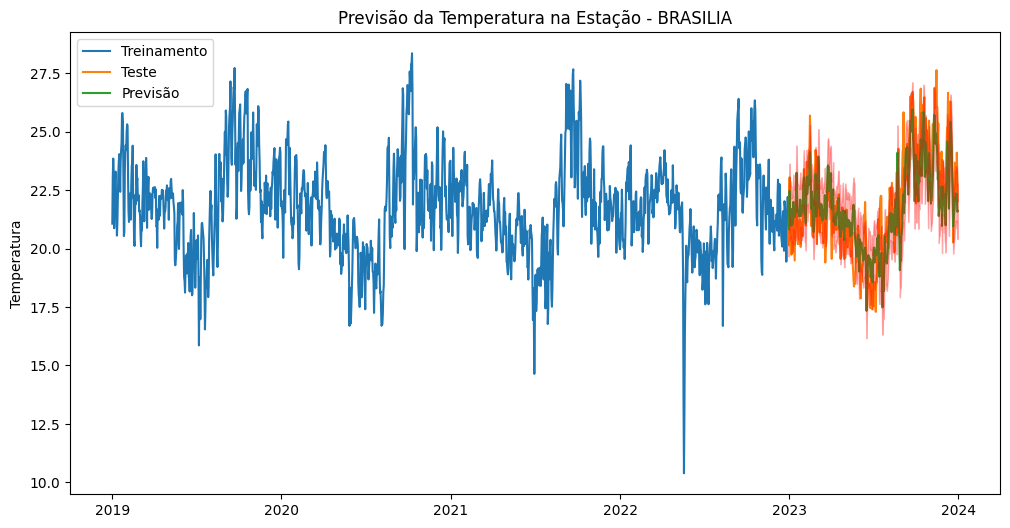

                                            SARIMAX Results                                             
Dep. Variable:     TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)   No. Observations:                 1460
Model:                                           ARIMA(3, 0, 1)   Log Likelihood               -1575.880
Date:                                          Sat, 28 Jun 2025   AIC                           3185.760
Time:                                                  22:02:07   BIC                           3275.626
Sample:                                              01-01-2019   HQIC                          3219.284
                                                   - 12-30-2022                                         
Covariance Type:                                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
co

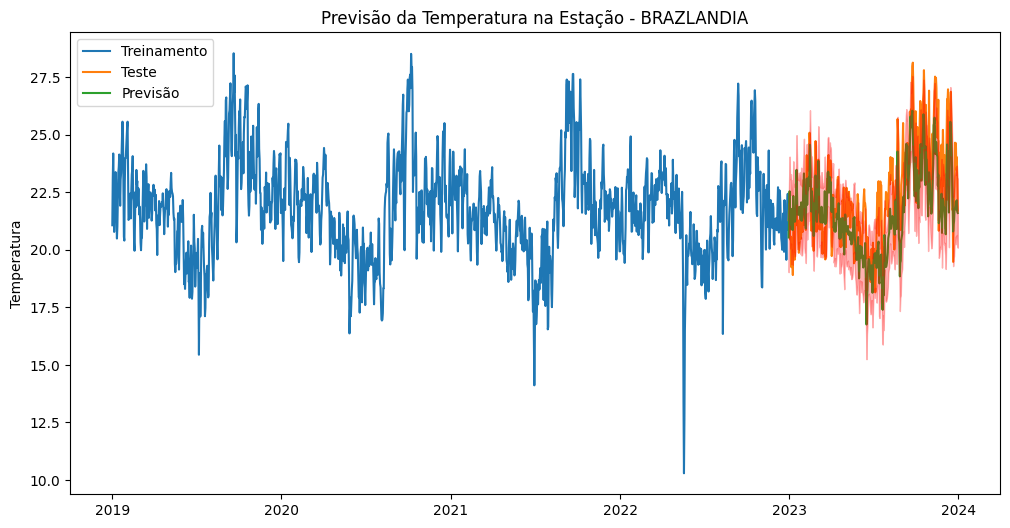

                                            SARIMAX Results                                             
Dep. Variable:     TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)   No. Observations:                 1460
Model:                                           ARIMA(3, 0, 1)   Log Likelihood               -1560.110
Date:                                          Sat, 28 Jun 2025   AIC                           3154.220
Time:                                                  22:02:28   BIC                           3244.085
Sample:                                              01-01-2019   HQIC                          3187.743
                                                   - 12-30-2022                                         
Covariance Type:                                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
co

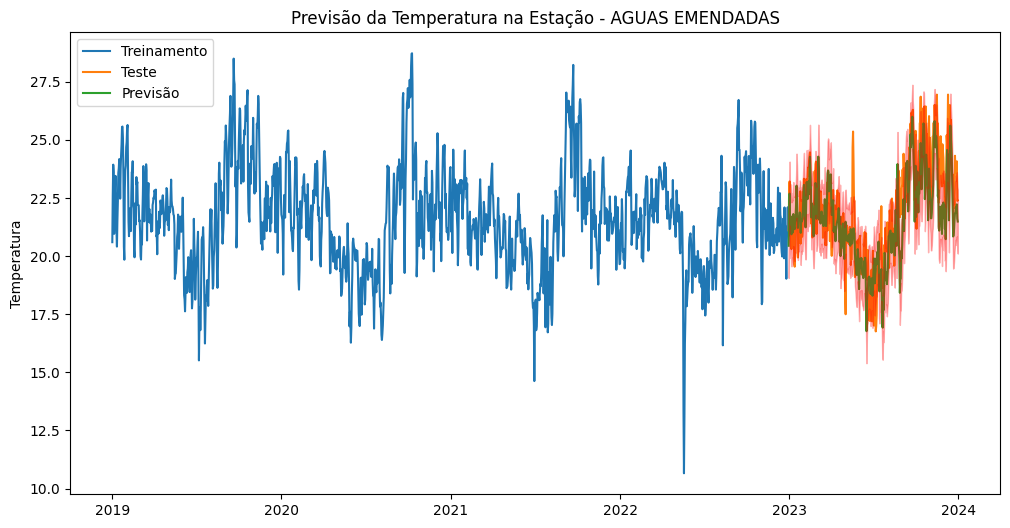

                                            SARIMAX Results                                             
Dep. Variable:     TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)   No. Observations:                 1460
Model:                                           ARIMA(3, 0, 1)   Log Likelihood               -1532.786
Date:                                          Sat, 28 Jun 2025   AIC                           3099.572
Time:                                                  22:02:56   BIC                           3189.437
Sample:                                              01-01-2019   HQIC                          3133.095
                                                   - 12-30-2022                                         
Covariance Type:                                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
co

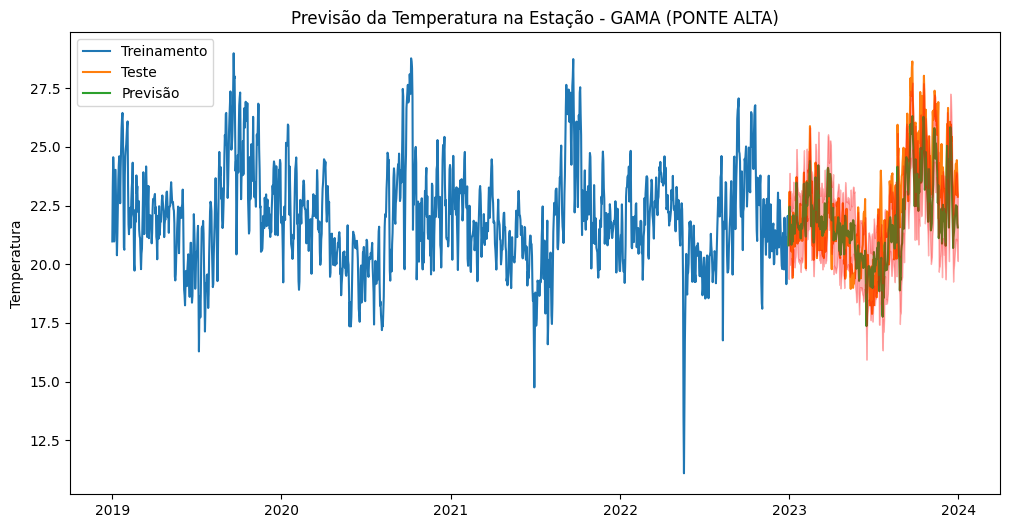

/home/juliababa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                            SARIMAX Results                                             
Dep. Variable:     TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)   No. Observations:                 1460
Model:                                           ARIMA(3, 0, 1)   Log Likelihood               -1550.650
Date:                                          Sat, 28 Jun 2025   AIC                           3135.301
Time:                                                  22:03:16   BIC                           3225.166
Sample:                                              01-01-2019   HQIC                          3168.824
                                                   - 12-30-2022                                         
Covariance Type:                                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
co

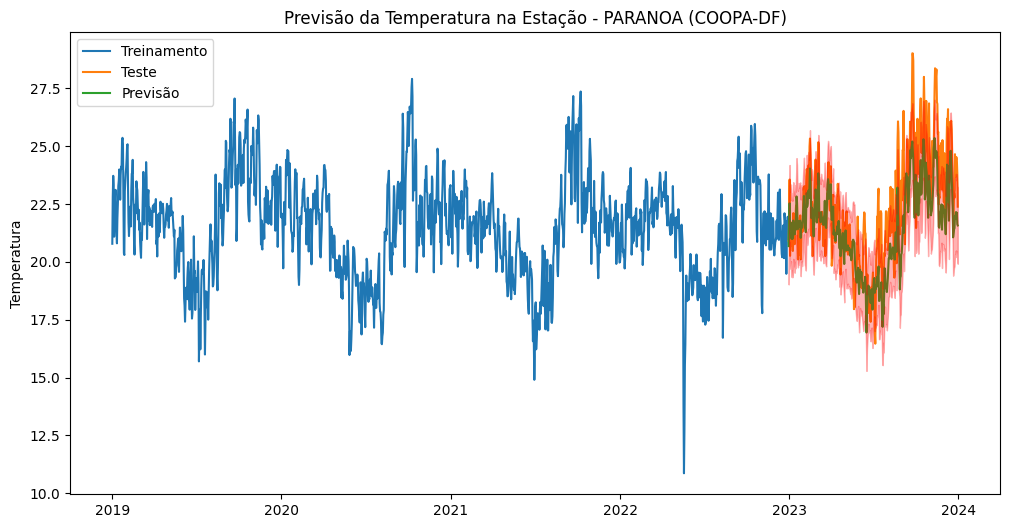

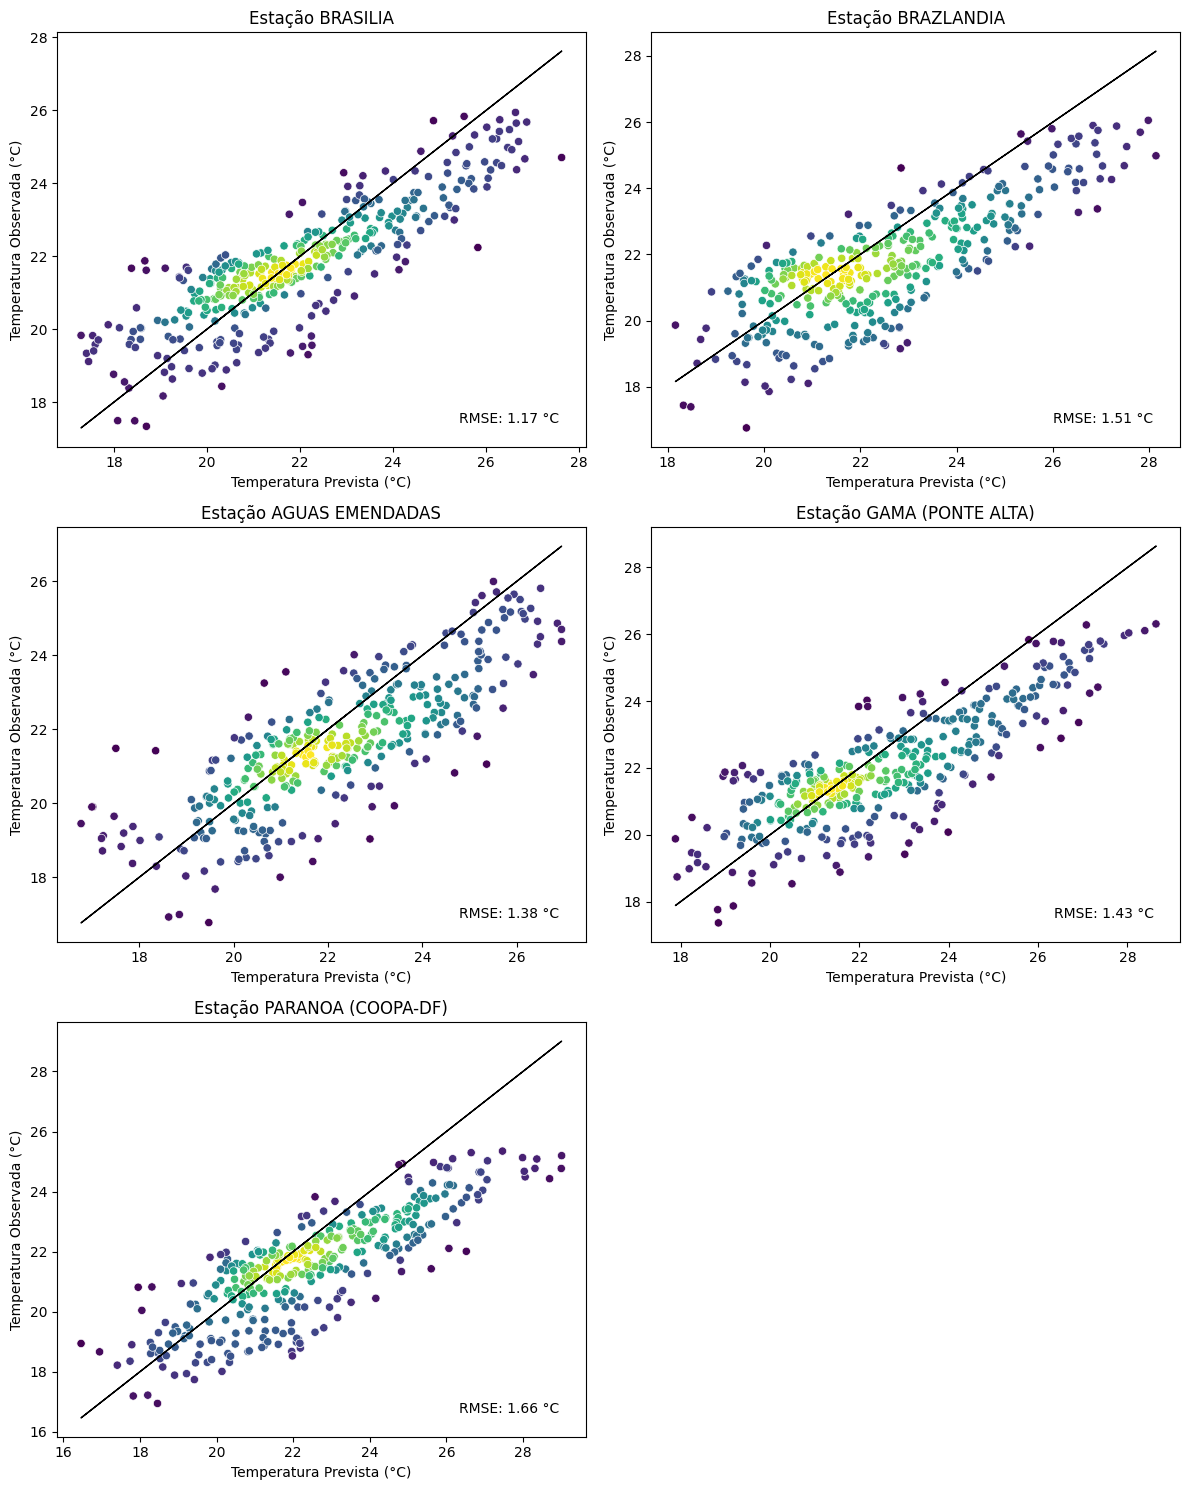

In [10]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import seaborn as sns


# df_nearest_stations_weather_data = []

# for filename in df_nearest_stations['Arquivo']: 
#     df_weather_data = pd.read_csv(f'../data/cleaned_data/2023_cleaned/{filename}', decimal=".", sep=";")
#     df_nearest_stations_weather_data.append(df_weather_data)

# df_compilation_of_nearest_stations_weather_data = pd.concat(df_nearest_stations_weather_data, ignore_index= True)

def clean_data(dataframe):
    df_cleaned = dataframe.drop(columns=['Hora UTC'])
    df_cleaned['Data'] = pd.to_datetime(df_cleaned['Data'])

    df_sorted = df_cleaned.sort_values(by='Data', ascending=True)
    df_sorted.set_index('Data', inplace=True)
    df_avarage_temperature_by_day = df_sorted.resample("D").mean()
    df_not_null_values_day = df_avarage_temperature_by_day.ffill()

    return df_not_null_values_day

def create_fourier_terms(t, period, num_terms):
    terms = []
    for i in range(1, num_terms + 1):
        terms.append(np.sin(2 * np.pi * i * t / period))
        terms.append(np.cos(2 * np.pi * i * t / period))
    return np.column_stack(terms)

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))


def get_forecast_test_graph(df_test, forecast, forecast_parameter, ax):
    import numpy as np
    from scipy import stats
    from sklearn.metrics import mean_squared_error
    import seaborn as sns

    values = np.vstack([df_test[forecast_parameter], forecast])
    kernel = stats.gaussian_kde(values)(values)

    # Scatterplot com seaborn no eixo fornecido
    sns.scatterplot(
        x=df_test[forecast_parameter],
        y=forecast,
        hue=kernel,
        palette="viridis",
        ax=ax,
        legend=False
    )

    mse = mean_squared_error(df_test[forecast_parameter], forecast)
    rmse = mse**0.5

    # Linha de referência x=y
    ax.plot(df_test[forecast_parameter], df_test[forecast_parameter], color='black', linewidth=1.0)

    # Texto RMSE
    ax.text(0.95, 0.05, f'RMSE: {rmse:.2f} °C', ha='right', va='bottom', transform=ax.transAxes, fontsize=10)

    ax.set_ylabel('Temperatura Observada (°C)')
    ax.set_xlabel('Temperatura Prevista (°C)')

def get_aggregated_graphs(df_tests, forecasts, forecast_parameter, stations_name):
    n_graphs = len(df_tests)
    n_cols = 2
    n_rows = (n_graphs + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))
    axes = axes.flatten()

    for i in range(n_graphs):
        get_forecast_test_graph(df_tests[i], forecasts[i], forecast_parameter, ax=axes[i])
        axes[i].set_title(f'Estação {stations_name[i]}')

    # Remove os eixos extras se n_graphs for ímpar
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def arima_forecast_with_fourier_terms(df_training, df_test, forecast_parameter, title):
    n = len(df_training[forecast_parameter])  # Number of data points
    t = np.arange(n)
    seasonality = 365

    num_fourier_terms = 4
    fourier_terms = create_fourier_terms(t, seasonality, num_fourier_terms)

    # Fit the ARIMA model using arima with Fourier terms as exogenous variables
    model = ARIMA(df_training[forecast_parameter],exog=fourier_terms[:n], order=(3,0,1))
    model_fit = model.fit()

    # Forecast future values with the fitted model
    forecast_exog = create_fourier_terms(np.arange(n, n + len(df_test)), seasonality, num_fourier_terms)

    # Get the forecast for the future steps with exogenous variables
    forecast_df = pd.DataFrame(forecast_exog, columns=[f'Fourier_{i+1}' for i in range(num_fourier_terms * 2)])

    # Fazer previsões
    forecast = model_fit.forecast(steps=len(df_test), exog=forecast_df)

    # Visualização das previsões
    plt.figure(figsize=(12,6))
    plt.plot(df_training.index, df_training[forecast_parameter], label='Treinamento')
    plt.plot(df_test.index, df_test[forecast_parameter], label='Teste')
    plt.plot(df_test.index, forecast, label='Previsão')
    plt.ylabel('Temperatura')
    plt.legend(loc='upper left')

    # Cálculo erro quadrático
    mse = mean_squared_error(df_test[forecast_parameter], forecast)
    rmse = mse**0.5
    smape_value = smape(df_test[forecast_parameter], forecast)
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'sMAPE: {smape_value}')
    plt.fill_between(df_test.index, (forecast-rmse), (forecast+rmse), alpha=.3, color='r', zorder=20)

    plt.title(title)

    plt.show()

    return forecast

def arima_forecast_with_fourier_terms_exog(df_training, df_test, df_test_without_the_station, forecast_parameter, title):
    n = len(df_training[forecast_parameter])  # Number of data points
    t = np.arange(n)
    seasonality = 365

    num_fourier_terms = 4
    fourier_terms = create_fourier_terms(t, seasonality, num_fourier_terms)

    exog_vars = ["RADIACAO GLOBAL (KJ/m²)", "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)", "UMIDADE RELATIVA DO AR, HORARIA (%)"]

    X_train_extra = df_training[exog_vars].values
    X_test_extra = df_test_without_the_station[exog_vars].values

    X_train_final = np.hstack([X_train_extra, fourier_terms[:n]])

    # Fit the ARIMA model using arima with Fourier terms as exogenous variables
    model = ARIMA(df_training[forecast_parameter],exog=X_train_final, order=(3,0,1))
    model_fit = model.fit()

    print(model_fit.summary())

    # Forecast future values with the fitted model
    forecast_exog = create_fourier_terms(np.arange(n, n + len(df_test)), seasonality, num_fourier_terms)

    X_test_final = np.hstack([X_test_extra, forecast_exog])

    # Get the forecast for the future steps with exogenous variables
    # forecast_df = pd.DataFrame(forecast_exog, columns=[f'Fourier_{i+1}' for i in range(num_fourier_terms * 2)])

    # Fazer previsões
    forecast = model_fit.forecast(steps=len(df_test), exog=X_test_final)

    # Visualização das previsões
    plt.figure(figsize=(12,6))
    plt.plot(df_training.index, df_training[forecast_parameter], label='Treinamento')
    plt.plot(df_test.index, df_test[forecast_parameter], label='Teste')
    plt.plot(df_test.index, forecast, label='Previsão')
    plt.ylabel('Temperatura')
    plt.legend(loc='upper left')

    # Cálculo erro quadrático
    mse = mean_squared_error(df_test[forecast_parameter], forecast)
    rmse = mse**0.5
    smape_value = smape(df_test[forecast_parameter], forecast)
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'sMAPE: {smape_value}')
    plt.fill_between(df_test.index, (forecast-rmse), (forecast+rmse), alpha=.3, color='r', zorder=20)

    plt.title(title)

    plt.show()

    return forecast

forecasts = []
df_tests = []
stations_name = []
forecast_parameter = 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'
for station in stations_data:
    cleaned_station_data = clean_data(station["station_data"])
    cleaned_nearest_stations_data = clean_data(station["nearest_stations_data"])


    # Divisão dos dados em treinamento (80%) e teste (20%)- MONTHLY
    training_data_length = int(len(cleaned_nearest_stations_data) * 0.8)
    df_training = cleaned_nearest_stations_data[:training_data_length]
    df_test = cleaned_station_data[training_data_length:]

    station_name = station["station_info"]["ESTAC?O:"].iloc[0]
    forecast = arima_forecast_with_fourier_terms(df_training, df_test, forecast_parameter, f'Previsão da Temperatura na Estação - {station_name}')
    # df_training_month, df_test_month = df_not_null_values_month[:df_splited_data_month], df_not_null_values_month[df_splited_data_month:]  

    forecasts.append(forecast)
    df_tests.append(df_test)
    stations_name.append(station_name)

get_aggregated_graphs(df_tests, forecasts, forecast_parameter, stations_name)


forecasts = []
df_tests = []
stations_name = []
for station in stations_data:
    cleaned_station_data = clean_data(station["station_data"])
    cleaned_nearest_stations_data = clean_data(station["nearest_stations_data"])


    # Divisão dos dados em treinamento (80%) e teste (20%)- MONTHLY
    training_data_length = int(len(cleaned_nearest_stations_data) * 0.8)
    df_training = cleaned_nearest_stations_data[:training_data_length]
    df_test_without_the_station = cleaned_nearest_stations_data[training_data_length:]
    df_test = cleaned_station_data[training_data_length:]

    station_name = station["station_info"]["ESTAC?O:"].iloc[0]
    forecast = arima_forecast_with_fourier_terms_exog(df_training, df_test, df_test_without_the_station, forecast_parameter, f'Previsão da Temperatura na Estação - {station_name}')
    # df_training_month, df_test_month = df_not_null_values_month[:df_splited_data_month], df_not_null_values_month[df_splited_data_month:]  

    forecasts.append(forecast)
    df_tests.append(df_test)
    stations_name.append(station_name)


get_aggregated_graphs(df_tests, forecasts, forecast_parameter, stations_name)


# df_cleaned = df_compilation_of_nearest_stations_weather_data.drop(columns=['Hora UTC'])

# df_cleaned['Data'] = pd.to_datetime(df_cleaned['Data'])

# df_sorted = df_cleaned.sort_values(by='Data', ascending=True)

# df_sorted.info()

# forecast_parameter = 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'

# # print(df_notimecollumn.info())
# # print(df_notimecollumn.info())
# #print(df_notimecollumn.groupby(['Data'], as_index= True).mean())

# print(df_sorted.info())

# #Converte Data
# #df_notimecollumn['Data']=pd.to_datetime(df_notimecollumn['Data'])
# df_sorted.set_index('Data', inplace=True)
# df_avarage_temperature_by_day = df_sorted.resample("D").mean()
# df_avarage_temperature_by_month = df_sorted.resample("M").mean()


# # Verificar se há valores nulos
# print(df_avarage_temperature_by_day.isnull().sum())

# # Tratar valores nulos
# df_not_null_values_day = df_avarage_temperature_by_day.ffill()
# df_not_null_values_month = df_avarage_temperature_by_month.ffill()

# Divisão dos dados em treinamento (80%) e teste (20%)- DAILY
# df_splited_data = int(len(df_not_null_values_day) * 0.8)
# df_training, df_test = df_not_null_values_day[:df_splited_data], df_not_null_values_day[df_splited_data:]  

# # Divisão dos dados em treinamento (80%) e teste (20%)- MONTHLY
# df_splited_data_month = int(len(df_not_null_values_month) * 0.8)
# df_training_month, df_test_month = df_not_null_values_month[:df_splited_data_month], df_not_null_values_month[df_splited_data_month:]  

In [11]:
df_training.corr()

,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",RADIACAO GLOBAL (Kj/m²)
"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)",1.000000,-0.351868,-0.349847,-0.356864,-0.192041,-0.028572,0.449583,-0.065742,0.017660,0.443702,0.454115,0.492851,0.505541,0.502792,0.370529,-0.024132,-0.055305,-0.509608
"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",-0.351868,1.000000,0.999856,0.999843,0.085845,-0.505195,-0.535100,-0.472979,-0.535313,-0.543932,-0.526357,-0.351559,-0.339706,-0.345855,-0.524615,0.147947,0.144502,0.197442
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),-0.349847,0.999856,1.000000,0.999680,0.086099,-0.502986,-0.533298,-0.470950,-0.532940,-0.542132,-0.524538,-0.350831,-0.338912,-0.345107,-0.524116,0.150569,0.146426,0.198751
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),-0.356864,0.999843,0.999680,1.000000,0.087660,-0.506524,-0.537913,-0.474041,-0.536994,-0.546644,-0.529230,-0.353685,-0.341993,-0.348104,-0.526576,0.144670,0.141766,0.200665
RADIACAO GLOBAL (KJ/m²),-0.192041,0.085845,0.086099,0.087660,1.000000,0.272243,-0.166377,0.287897,0.250683,-0.158708,-0.172270,-0.288924,-0.293020,-0.292815,-0.163232,0.127449,0.138901,NaN
"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",-0.028572,-0.505195,-0.502986,-0.506524,0.272243,1.000000,0.187552,0.995482,0.994910,0.202921,0.173723,-0.224260,-0.231417,-0.228823,0.054433,0.042102,0.029066,0.318671
TEMPERATURA DO PONTO DE ORVALHO (°C),0.449583,-0.535100,-0.533298,-0.537913,-0.166377,0.187552,1.000000,0.115004,0.264088,0.999320,0.999416,0.906817,0.899307,0.903794,0.467930,-0.213719,-0.218209,-0.491889
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),-0.065742,-0.472979,-0.470950,-0.474041,0.287897,0.995482,0.115004,1.000000,0.981852,0.131710,0.099885,-0.293804,-0.304829,-0.300078,0.025089,0.030531,0.016199,0.374157
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),0.017660,-0.535313,-0.532940,-0.536994,0.250683,0.994910,0.264088,0.981852,1.000000,0.277911,0.251771,-0.147289,-0.150636,-0.149729,0.088771,0.056724,0.044662,0.249327
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),0.443702,-0.543932,-0.542132,-0.546644,-0.158708,0.202921,0.999320,0.131710,0.277911,1.000000,0.997720,0.901137,0.891364,0.896821,0.467863,-0.228160,-0.232850,-0.473474


In [12]:
# import matplotlib.pyplot as plt
# from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# from sklearn.metrics import mean_squared_error

# # df_nearest_stations_weather_data = []

# # for filename in df_nearest_stations['Arquivo']: 
# #     df_weather_data = pd.read_csv(f'../data/cleaned_data/2023_cleaned/{filename}', decimal=".", sep=";")
# #     df_nearest_stations_weather_data.append(df_weather_data)

# # df_compilation_of_nearest_stations_weather_data = pd.concat(df_nearest_stations_weather_data, ignore_index= True)

# # for filename in df_point_stations['INMET_CO_DF_A001_BRASILIA_01-01-2019_A_31-12-2019.CSV']:
# filename = "INMET_CO_DF_A001_BRASILIA_01-01-2019_A_31-12-2019.CSV"
# yeardirectoryfilename.append(filename)

# df_weather_data = pd.read_csv(f'../data/cleaned_data/2019_cleaned/{filename}', decimal=".", sep=";")
# df_nearest_stations_weather_data.append(df_weather_data)

# df_weather_data = pd.read_csv(f'../data/cleaned_data/2020_cleaned/{filename.replace("2019", "2020")}', decimal=".", sep=";")
# df_nearest_stations_weather_data.append(df_weather_data)

# df_weather_data = pd.read_csv(f'../data/cleaned_data/2021_cleaned/{filename.replace("2019", "2021")}', decimal=".", sep=";")
# df_nearest_stations_weather_data.append(df_weather_data)

# df_weather_data = pd.read_csv(f'../data/cleaned_data/2022_cleaned/{filename.replace("2019", "2022")}', decimal=".", sep=";")
# df_nearest_stations_weather_data.append(df_weather_data)

# df_weather_data = pd.read_csv(f'../data/cleaned_data/2023_cleaned/{filename.replace("2019", "2023")}', decimal=".", sep=";")
# df_nearest_stations_weather_data.append(df_weather_data)

# df_compilation_of_nearest_stations_weather_data_point = pd.concat(df_nearest_stations_weather_data, ignore_index= True)

# df_cleaned_point_station = df_compilation_of_nearest_stations_weather_data_point.drop(columns=['Hora UTC'])

# df_cleaned_point_station['Data'] = pd.to_datetime(df_cleaned_point_station['Data'])

# df_sorted_point_station = df_cleaned_point_station.sort_values(by='Data', ascending=True)

# df_sorted_point_station.info()

# forecast_parameter = 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'

# # print(df_notimecollumn.info())
# # print(df_notimecollumn.info())
# #print(df_notimecollumn.groupby(['Data'], as_index= True).mean())

# print(df_sorted_point_station.info())

# #Converte Data
# #df_notimecollumn['Data']=pd.to_datetime(df_notimecollumn['Data'])
# df_sorted_point_station.set_index('Data', inplace=True)
# df_avarage_temperature_by_day_point_data = df_sorted_point_station.resample("D").mean()

# # Verificar se há valores nulos
# print(df_avarage_temperature_by_day_point_data.isnull().sum())

# # Tratar valores nulos
# df_not_null_values_day_point_data = df_avarage_temperature_by_day_point_data.ffill()

# # Divisão dos dados em treinamento (80%) e teste (20%)- DAILY
# df_splited_data_point_data = int(len(df_not_null_values_day_point_data) * 0.8)
# df_training_point_data, df_test_point_data = df_not_null_values_day_point_data[:df_splited_data], df_not_null_values_day_point_data[df_splited_data:]  

# df_test_point_data

In [13]:
# n = len(df_training[forecast_parameter])  # Number of data points
# t = np.arange(n)
# seasonality = 365  

# # Create Fourier terms
# def create_fourier_terms(t, period, num_terms):
#     terms = []
#     for i in range(1, num_terms + 1):
#         terms.append(np.sin(2 * np.pi * i * t / period))
#         terms.append(np.cos(2 * np.pi * i * t / period))
#     return np.column_stack(terms)

# num_fourier_terms = 4
# fourier_terms = create_fourier_terms(t, seasonality, num_fourier_terms)

# # Fit the ARIMA model using arima with Fourier terms as exogenous variables
# model = ARIMA(df_training[forecast_parameter],exog=fourier_terms[:n], order=(1,0,0), trend='ct')
# model_fit = model.fit()

# # Forecast future values with the fitted model
# forecast_exog = create_fourier_terms(np.arange(n, n + len(df_test_point_data)), seasonality, num_fourier_terms)

# # Get the forecast for the future steps with exogenous variables
# forecast_df = pd.DataFrame(forecast_exog, columns=[f'Fourier_{i+1}' for i in range(num_fourier_terms * 2)])

# # Fazer previsões
# forecast = model_fit.forecast(steps=len(df_test_point_data), exog=forecast_df)

# # Visualização das previsões
# plt.figure(figsize=(12,6))
# plt.plot(df_training.index, df_training[forecast_parameter], label='Treinamento')
# plt.plot(df_test_point_data.index, df_test_point_data[forecast_parameter], label='Teste')
# plt.plot(df_test_point_data.index, forecast, label='Previsão')
# plt.ylabel('Temperatura')
# plt.legend(loc='upper left')

# # Cálculo erro quadrático
# mse = mean_squared_error(df_test_point_data[forecast_parameter], forecast)
# rmse = mse**0.5 
# print(f'MSE: {mse}')
# print(f'RMSE: {rmse}')
# plt.fill_between(df_test_point_data.index, (forecast-rmse), (forecast+rmse), alpha=.3, color='r', zorder=20)

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Função adaptada com rolling forecast e variáveis exógenas
def arima_rolling_forecast_with_fourier_and_exog(df_training, df_test, df_test_without_the_station, forecast_parameter, exog_vars, num_fourier_terms=4, order=(3,0,1), seasonality=365):
    from statsmodels.tsa.arima.model import ARIMA

    # Série completa para rolling
    full_series = pd.concat([df_training, df_test])
    full_index = full_series.index
    full_y = full_series[forecast_parameter].values

    # Concatenação das exógenas (real) + Fourier
    full_exog_df = pd.concat([df_training[exog_vars], df_test_without_the_station[exog_vars]])
    n_train = len(df_training)
    n_test = len(df_test)

    forecast_rolling = []
    actuals = []

    for i in range(n_test):
        end_idx = n_train + i

        # y de treino
        y_train = full_y[:end_idx]

        # t para fourier
        t_train = np.arange(end_idx)
        t_forecast = np.array([end_idx])

        # Fourier
        fourier_train = create_fourier_terms(t_train, seasonality, num_fourier_terms)
        fourier_forecast = create_fourier_terms(t_forecast, seasonality, num_fourier_terms)

        # Exógenas
        X_train_extra = full_exog_df.iloc[:end_idx].values
        X_forecast_extra = full_exog_df.iloc[[end_idx]].values

        # Concatena exógenas com Fourier
        X_train = np.hstack([X_train_extra, fourier_train])
        X_forecast = np.hstack([X_forecast_extra, fourier_forecast])

        try:
            model = ARIMA(y_train, exog=X_train, order=order, trend='ct')
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=1, exog=X_forecast)

            forecast_rolling.append(forecast[0])
            actuals.append(full_y[end_idx])
        except Exception as e:
            forecast_rolling.append(np.nan)
            actuals.append(full_y[end_idx])

    # Cálculo do erro
    rmse = mean_squared_error(actuals, forecast_rolling, squared=False)

    # Gráfico
    plt.figure(figsize=(12, 6))
    plt.plot(df_test.index, actuals, label='Observado')
    plt.plot(df_test.index, forecast_rolling, label='Rolling Forecast (1 dia)')
    plt.fill_between(df_test.index,
                     np.array(forecast_rolling) - rmse,
                     np.array(forecast_rolling) + rmse,
                     alpha=0.3, color='red', label='±RMSE')
    plt.legend()
    plt.ylabel('Temperatura')
    plt.title('Rolling Forecast com ARIMA + Fourier + Exógenas')
    plt.show()

    return forecast_rolling, actuals, rmse



{'code': 'A001', 'station_info':     REGI?O: UF:  ESTAC?O: CODIGO (WMO):   LATITUDE:  LONGITUDE: ALTITUDE:  \
442      CO  DF  BRASILIA          A001  -15.789343  -47.925756   1160.96   

                                               Arquivo  
442  INMET_CO_DF_A001_BRASILIA_01-01-2019_A_31-12-2...  , 'nearest_stations_info':     REGI?O: UF:            ESTAC?O: CODIGO (WMO):     LATITUDE:    LONGITUDE:  \
2        CO  DF  PARANOA (COOPA-DF)          A047    -16.012222    -47.557417   
141      CO  DF          BRAZLANDIA          A042  -15.59972221   -48.1311111   
233      CO  DF     AGUAS EMENDADAS          A045    -15.596491    -47.625801   
239      CO  DF   GAMA (PONTE ALTA)          A046  -15.93527777  -48.13749999   

    ALTITUDE:                                            Arquivo  Distancia  
2      1043.0  INMET_CO_DF_A047_PARANOA (COOPA-DF)_01-01-2019...  46.520207  
141    1143.0  INMET_CO_DF_A042_BRAZLANDIA_01-01-2019_A_31-12...  30.411300  
233   1030.36  INMET_CO_DF_A045_

/home/juliababa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/juliababa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/juliababa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/juliababa/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/juliababa/.local/lib/python3.10/site-packages/statsmodels/

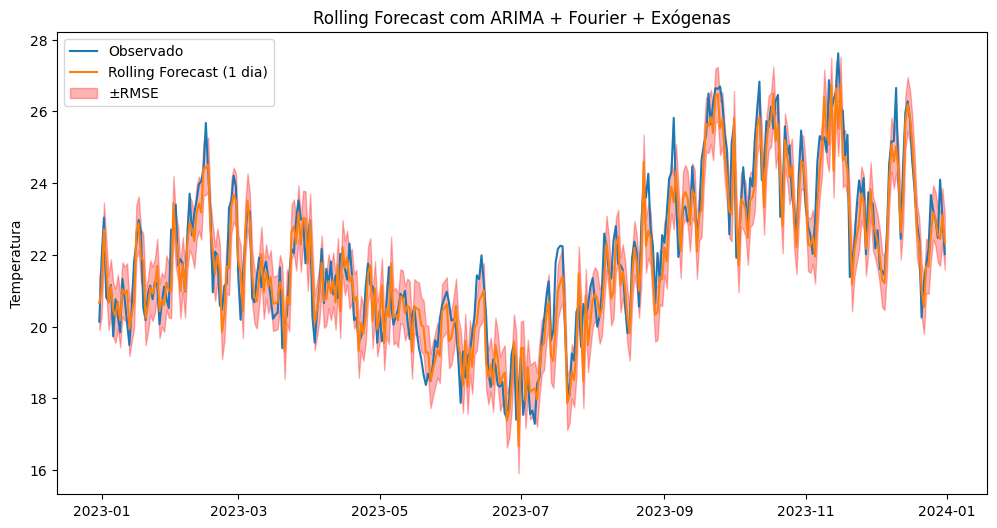

0.754574897407103


In [15]:
forecast_parameter = 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'
exog_vars = [
    "RADIACAO GLOBAL (KJ/m²)",
    "PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",
    "UMIDADE RELATIVA DO AR, HORARIA (%)"
]

station = stations_data[0]

print(station)

cleaned_station_data = clean_data(station["station_data"])
cleaned_nearest_stations_data = clean_data(station["nearest_stations_data"])


# Divisão dos dados em treinamento (80%) e teste (20%)- MONTHLY
training_data_length = int(len(cleaned_nearest_stations_data) * 0.8)
df_training = cleaned_nearest_stations_data[:training_data_length]
df_test_without_the_station = cleaned_nearest_stations_data[training_data_length:]
df_test = cleaned_station_data[training_data_length:]

station_name = station["station_info"]["ESTAC?O:"].iloc[0]

forecast, actuals, rmse = arima_rolling_forecast_with_fourier_and_exog(
    df_training,
    df_test,
    df_test_without_the_station,
    forecast_parameter,
    exog_vars
)

print(rmse)
